# November Census Analysis

In [2]:
import polars as pl
import requests
import tempfile
import os
from pathlib import Path
import re


In [3]:
df = pl.read_parquet("../data/sms_census_data_version_109.parquet")

In [4]:
null_summary = (
    df.select([
        ((pl.col(col).is_null().sum() / pl.len()) * 100).alias(col)
        for col in df.columns
    ])
    .unpivot(variable_name="column", value_name="null_percentage")
    .sort("null_percentage", descending=True)
)



In [5]:
null_summary.head(10)

column,null_percentage
str,f64
"""fax""",75.372524
"""dba_name""",73.425641
"""vmt_source_id""",58.794277
"""mcs150_mileage_year""",37.645953
"""mcs150_mileage""",34.461635
"""email_address""",23.907221
"""mcs150_date""",8.106657
"""nbr_power_unit""",3.794021
"""telephone""",0.550364


In [6]:
df = df.with_columns([
    pl.col("mcs150_mileage").is_null().alias("is_mcs150_mileage_null"),
    pl.col("mcs150_mileage_year").is_null().alias("is_mcs150_mileage_year_null"),
    pl.col("mcs150_date").is_null().alias("is_mcs150_date_null"),
    (pl.col("recent_mileage") == 0).alias("is_recent_mileage_zero"),
    (pl.col("recent_mileage_year") == 0).alias("is_recent_mileage_year_zero"),
])

In [7]:
df.group_by("vmt_source_id").agg([
          pl.mean("is_mcs150_mileage_null").alias("mcs150_mileage_null_rate"),
          pl.mean("is_mcs150_mileage_year_null").alias("mcs150_mileage_year_null_rate"),
          pl.mean("is_mcs150_date_null").alias("mcs150_date_null_rate"),
          pl.mean("is_recent_mileage_zero").alias("recent_mileage_zero_rate"),
          pl.mean("is_recent_mileage_year_zero").alias("recent_mileage_year_zero_rate"),
         
          pl.len().alias("n_rows")
      ]).sort("vmt_source_id")

vmt_source_id,mcs150_mileage_null_rate,mcs150_mileage_year_null_rate,mcs150_date_null_rate,recent_mileage_zero_rate,recent_mileage_year_zero_rate,n_rows
i64,f64,f64,f64,f64,f64,u32
null,0.585344,0.639042,0.137287,0.999998,0.999998,1229590
1,0.0,0.000227,0.000595,0.0,0.0,847037
2,0.111544,0.157566,0.018721,0.0,0.0,1282
3,0.062156,0.085753,0.015111,0.0,0.0,13434


In [8]:
df.filter(pl.col("vmt_source_id").is_not_null()).select(
    (pl.col("mcs150_mileage") == pl.col("recent_mileage")).mean().alias("pct_same_mileage"),
    (pl.col("mcs150_mileage_year") == pl.col("recent_mileage_year")).mean().alias("pct_same_year"),
)

pct_same_mileage,pct_same_year
f64,f64
0.986424,0.984941


In [9]:
(
    df.filter(pl.col("vmt_source_id").is_not_null())
      .with_columns(
          (pl.col("mcs150_mileage") == pl.col("recent_mileage")).alias("same_mileage")
      )
      .group_by("vmt_source_id")
      .agg([
          pl.mean("same_mileage").alias("pct_same_mileage"),
          pl.len().alias("n_rows")
      ])
)


vmt_source_id,pct_same_mileage,n_rows
i64,f64,u32
2,0.007024,1282
1,1.0,847037
3,0.162235,13434


In [10]:
df.describe()

statistic,phy_state,phy_country,phy_zip,phy_street,mailing_street,carrier_operation,phy_city,oic_state,email_address,mailing_city,mailing_zip,vmt_source_id,recent_mileage_year,mailing_state,mailing_country,mcs150_mileage_year,dba_name,legal_name,migrant,private_only,mcs150_mileage,telephone,exempt_for_hire,recent_mileage,hm_flag,private_property,state_government,fax,nbr_power_unit,dot_number,authorized_for_hire,federal_government,pc_flag,local_government,us_mail,op_other,private_passenger_nonbusiness,indian_tribe,private_passenger_business,driver_total,add_date,mcs150_date,is_mcs150_mileage_null,is_mcs150_mileage_year_null,is_mcs150_date_null,is_recent_mileage_zero,is_recent_mileage_year_zero
str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64
"""count""","""2089788""","""2091343""","""2089748""","""2089788""","""2089759""","""2091343""","""2089788""","""2091343""","""1591361""","""2089759""","""2089752""",861753.0,2.091343e6,"""2089759""","""2089759""",1.304037e6,"""555761""","""2091342""",2.091343e6,2.091343e6,1.370632e6,"""2079833""",2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,"""515045""",2.011997e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,"""2091288""",2.091343e6,2.091343e6,2.091343e6,2.088462e6,"""2091343""","""1921805""",2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6
"""null_count""","""1555""","""0""","""1595""","""1555""","""1584""","""0""","""1555""","""0""","""499982""","""1584""","""1591""",1.22959e6,0.0,"""1584""","""1584""",787306.0,"""1535582""","""1""",0.0,0.0,720711.0,"""11510""",0.0,0.0,0.0,0.0,0.0,"""1576298""",79346.0,0.0,0.0,0.0,0.0,0.0,0.0,"""55""",0.0,0.0,0.0,2881.0,"""0""","""169538""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,null,null,null,null,null,null,1.032666,833.766581,null,null,2021.888354,null,null,0.00041,0.368494,334483.120545,null,0.064946,173492.090417,0.004091,0.44236,0.00308,null,40.502297,2.7121e6,0.561893,0.001839,0.017602,0.003044,0.002571,null,0.010088,0.000526,0.017709,6.164491,null,null,0.344616,0.37646,0.081067,0.587942,0.587942
"""std""",null,null,null,null,null,null,null,null,null,null,null,0.250554,998.22136,null,null,146.64306,null,null,null,null,2.1201e7,null,null,1.4252e7,null,null,null,null,2806.729861,1.1718e6,null,null,null,null,null,null,null,null,null,366.795414,null,null,null,null,null,null,null
"""min""","""AB""","""BZ""","""0000""","""# 1 CAVE INDUSTRIAL DRIVE""","""# 1 CAVE INDUSTRIAL DRIVE""","""A""","""-----BR""","""AK""","""!@""","""-----""","""0000""",1.0,0.0,"""AB""","""AZ""",0.0,"""#1""","""#1 TRUCK DOCTORS""",0.0,0.0,0.0,"""( 3) 039-1812""",0.0,0.0,0.0,0.0,0.0,"""( ) - 0""",0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""#2 HEATING OIL""",0.0,0.0,0.0,0.0,"""01-APR-00""","""01-APR-01""",0.0,0.0,0.0,0.0,0.0
"""25%""",null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,null,2020.0,null,null,null,null,2644.0,null,null,0.0,null,null,null,null,1.0,1.772031e6,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,null,2023.0,null,null,null,null,20000.0,null,null,0.0,null,null,null,null,1.0,2.764674e6,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,1.0,2023.0,null,null,2024.0,null,null,null,null,79052.0,null,null,18000.0,null,null,null,null,2.0,3.743679e6,null,null,null,null,null,null,null,null,null,2.0,null,null,null,null,null,null,null
"""max""","""ZA""","""US""","""Y1A 8C4""","""ZUAZUA OTE 324""","""ZONA INDUSTRIAL JULIO N MATOS""","""C""","""ZYPHERHILLS""","""XX""","""��SANTIAGO@SVCRUZ.COM""","""ZYPHERHILLS""","""Y1A 6M8""",3.0,9999.0,"""ZA""","""WS""",9999.0,"""`""","""ZZZZZ'S MOVING LLC""",1.0,1.0,9.5372e9,"""(999) 999-9999""",1.0,9.5372e9,1.0,1.0,1.0,"""(999) 999-

In [11]:
df.select(pl.all().exclude(pl.String)).describe()

statistic,vmt_source_id,recent_mileage_year,mcs150_mileage_year,migrant,private_only,mcs150_mileage,exempt_for_hire,recent_mileage,hm_flag,private_property,state_government,nbr_power_unit,dot_number,authorized_for_hire,federal_government,pc_flag,local_government,us_mail,private_passenger_nonbusiness,indian_tribe,private_passenger_business,driver_total,is_mcs150_mileage_null,is_mcs150_mileage_year_null,is_mcs150_date_null,is_recent_mileage_zero,is_recent_mileage_year_zero
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",861753.0,2.091343e6,1.304037e6,2.091343e6,2.091343e6,1.370632e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.011997e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.088462e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6,2.091343e6
"""null_count""",1.22959e6,0.0,787306.0,0.0,0.0,720711.0,0.0,0.0,0.0,0.0,0.0,79346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2881.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.032666,833.766581,2021.888354,0.00041,0.368494,334483.120545,0.064946,173492.090417,0.004091,0.44236,0.00308,40.502297,2.7121e6,0.561893,0.001839,0.017602,0.003044,0.002571,0.010088,0.000526,0.017709,6.164491,0.344616,0.37646,0.081067,0.587942,0.587942
"""std""",0.250554,998.22136,146.64306,null,null,2.1201e7,null,1.4252e7,null,null,null,2806.729861,1.1718e6,null,null,null,null,null,null,null,null,366.795414,null,null,null,null,null
"""min""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.0,0.0,2020.0,null,null,2644.0,null,0.0,null,null,null,1.0,1.772031e6,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null
"""50%""",1.0,0.0,2023.0,null,null,20000.0,null,0.0,null,null,null,1.0,2.764674e6,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null
"""75%""",1.0,2023.0,2024.0,null,null,79052.0,null,18000.0,null,null,null,2.0,3.743679e6,null,null,null,null,null,null,null,null,2.0,null,null,null,null,null
"""max""",3.0,9999.0,9999.0,1.0,1.0,9.5372e9,1.0,9.5372e9,1.0,1.0,1.0,1.299987e6,4.488983e6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,199998.0,1.0,1.0,1.0,1.0,1.0


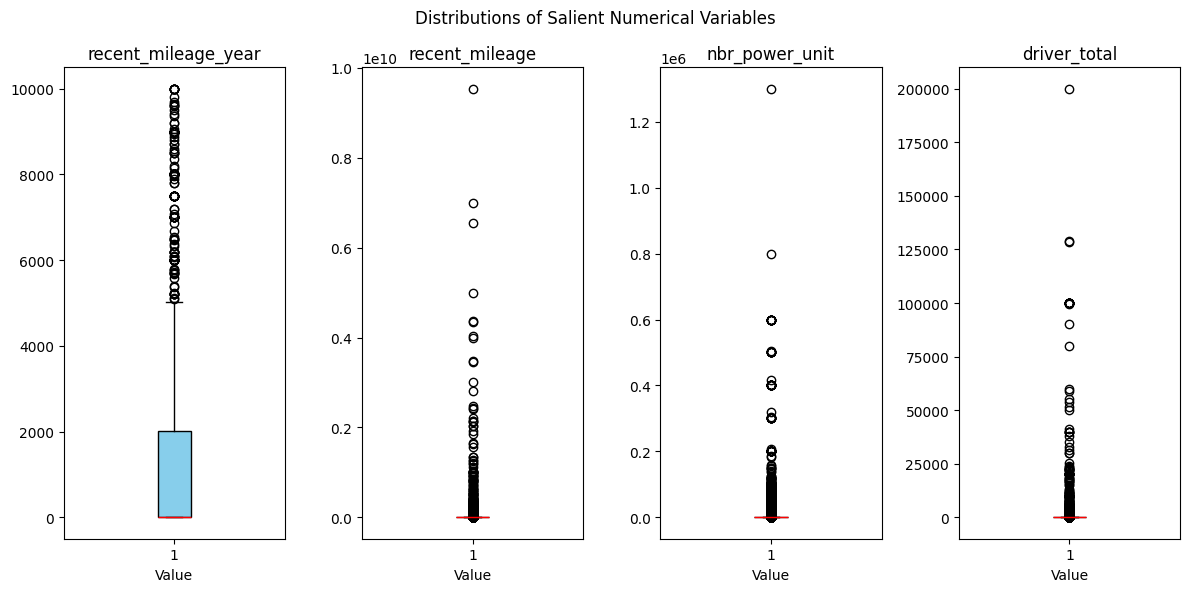

In [12]:
import matplotlib.pyplot as plt

numerics = [
    'recent_mileage_year', 
    'recent_mileage', 
    'nbr_power_unit', 
    'driver_total'
]

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(numerics):
    axes[i].boxplot(df[col].drop_nulls().to_numpy(),
                    patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")

fig.suptitle("Distributions of Salient Numerical Variables")
plt.tight_layout()
plt.show()
fig.savefig("numeric_boxplots.png", dpi=300, bbox_inches="tight")


In [13]:
df.select(numerics).describe()

statistic,recent_mileage_year,recent_mileage,nbr_power_unit,driver_total
str,f64,f64,f64,f64
"""count""",2.091343e6,2.091343e6,2.011997e6,2.088462e6
"""null_count""",0.0,0.0,79346.0,2881.0
"""mean""",833.766581,173492.090417,40.502297,6.164491
"""std""",998.22136,1.4252e7,2806.729861,366.795414
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,1.0,1.0
"""50%""",0.0,0.0,1.0,1.0
"""75%""",2023.0,18000.0,2.0,2.0
"""max""",9999.0,9.5372e9,1.299987e6,199998.0


In [14]:
df = df.with_columns([
    pl.when(pl.col("nbr_power_unit") > 0)
      .then(pl.col("driver_total") / pl.col("nbr_power_unit"))
      .otherwise(None)
      .alias("drivers_per_unit")
])

In [15]:
df["drivers_per_unit"].describe()

statistic,value
str,f64
"""count""",1.962676e6
"""null_count""",128667.0
"""mean""",2.192556
"""std""",231.890068
"""min""",0.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",100000.0


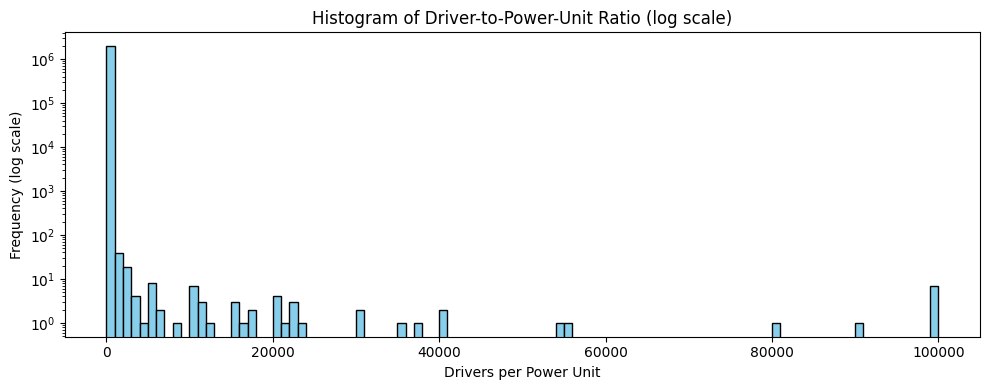

In [16]:
import numpy as np

ratio = df["drivers_per_unit"].drop_nulls().to_numpy()

fig, axes = plt.subplots(1, 1, figsize=(10, 4))

axes.hist(ratio, bins=100, color='skyblue', edgecolor='black', log=True)
axes.set_xlabel("Drivers per Power Unit")
axes.set_ylabel("Frequency (log scale)")
axes.set_title("Histogram of Driver-to-Power-Unit Ratio (log scale)")


plt.tight_layout()
plt.show()

fig.savefig("ndriver-ratio.png", dpi=300, bbox_inches="tight")
fig.savefig("driver-ratio.svg", bbox_inches="tight")


In [17]:
df = df.with_columns([
    pl.when(pl.col("nbr_power_unit") > 0)
      .then(pl.col("recent_mileage") / pl.col("nbr_power_unit"))
      .otherwise(None)
      .alias("mileage_per_truck"),
    pl.when(pl.col("driver_total") > 0)
      .then(pl.col("recent_mileage") / pl.col("driver_total"))
      .otherwise(None)
      .alias("mileage_per_driver"),
])

In [18]:
df.select("^mileage_per.*$").describe()


statistic,mileage_per_truck,mileage_per_driver
str,f64,f64
"""count""",1.963821e6,2.074462e6
"""null_count""",127522.0,16881.0
"""mean""",44860.484952,47987.700156
"""std""",7.9655e6,1.0800e7
"""min""",0.0,0.0
"""25%""",0.0,0.0
"""50%""",0.0,0.0
"""75%""",10000.0,10000.0
"""max""",7.0000e9,9.5372e9


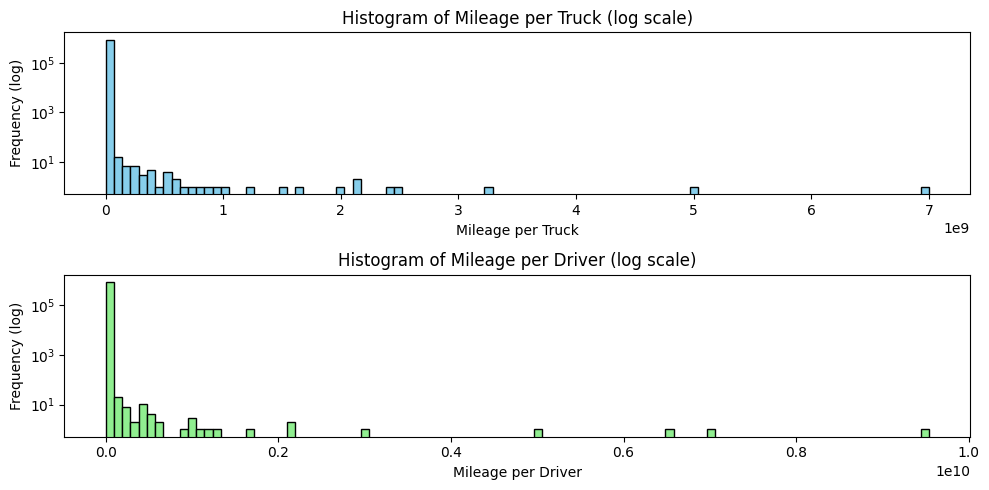

In [19]:
mileage_truck = df["mileage_per_truck"].drop_nulls().to_numpy()
mileage_driver = df["mileage_per_driver"].drop_nulls().to_numpy()

clip_value = 200_000 
mileage_truck_clipped = np.clip(mileage_truck, 0, clip_value)
mileage_driver_clipped = np.clip(mileage_driver, 0, clip_value)

fig, axes = plt.subplots(2, 1, figsize=(10, 5))

axes[0].hist(mileage_truck[mileage_truck>0], bins=100, color='skyblue', edgecolor='black', log=True)
axes[0].set_title("Histogram of Mileage per Truck (log scale)")
axes[0].set_xlabel("Mileage per Truck")
axes[0].set_ylabel("Frequency (log)")

axes[1].hist(mileage_driver[mileage_driver>0], bins=100, color='lightgreen', edgecolor='black', log=True)
axes[1].set_title("Histogram of Mileage per Driver (log scale)")
axes[1].set_xlabel("Mileage per Driver")
axes[1].set_ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

fig.savefig("mileage-ratio.png", dpi=300, bbox_inches="tight")
fig.savefig("mileage-ratio.svg", bbox_inches="tight")


In [20]:
df.columns

['phy_state',
 'phy_country',
 'phy_zip',
 'phy_street',
 'mailing_street',
 'carrier_operation',
 'phy_city',
 'oic_state',
 'email_address',
 'mailing_city',
 'mailing_zip',
 'vmt_source_id',
 'recent_mileage_year',
 'mailing_state',
 'mailing_country',
 'mcs150_mileage_year',
 'dba_name',
 'legal_name',
 'migrant',
 'private_only',
 'mcs150_mileage',
 'telephone',
 'exempt_for_hire',
 'recent_mileage',
 'hm_flag',
 'private_property',
 'state_government',
 'fax',
 'nbr_power_unit',
 'dot_number',
 'authorized_for_hire',
 'federal_government',
 'pc_flag',
 'local_government',
 'us_mail',
 'op_other',
 'private_passenger_nonbusiness',
 'indian_tribe',
 'private_passenger_business',
 'driver_total',
 'add_date',
 'mcs150_date',
 'is_mcs150_mileage_null',
 'is_mcs150_mileage_year_null',
 'is_mcs150_date_null',
 'is_recent_mileage_zero',
 'is_recent_mileage_year_zero',
 'drivers_per_unit',
 'mileage_per_truck',
 'mileage_per_driver']

In [21]:
df_zip = df.filter(
    pl.col("phy_zip").is_not_null() & (pl.col("phy_zip") != "")
).with_columns(
    pl.col("phy_zip").str.slice(0, 5).alias("phy_zip")
).group_by("phy_zip").agg(
        pl.len().alias("company_count"),
        pl.col("driver_total").sum().alias("total_drivers"),
        pl.col("nbr_power_unit").sum().alias("total_trucks")
).sort("company_count", descending=True)

In [22]:
df_zip


phy_zip,company_count,total_drivers,total_trucks
str,u32,i64,i64
"""93722""",2447,7325,75797
"""93313""",2014,6203,16835
"""78045""",1979,22694,18190
"""92154""",1929,8813,8099
"""92335""",1917,105043,10104
…,…,…,…
"""N4W 1""",1,3,3
"""06758""",1,1,1
"""31059""",1,3,3


In [23]:
import geopandas as gpd

zcta_raw = gpd.read_file("../data/geodata/tl_2020_us_zcta520/tl_2020_us_zcta520.shp")

In [24]:
zcta_raw.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.6539, -88.24713 33.6541..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.3496, -86.81648 34.3496..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."


In [25]:
zcta = zcta_raw[["ZCTA5CE20", "geometry"]]

In [26]:
zip_pd = df_zip.to_pandas()

In [27]:
zcta_stats = zcta.merge(
    zip_pd,
    left_on="ZCTA5CE20",
    right_on="phy_zip",
    how="left"
)

In [28]:
zcta_stats

,ZCTA5CE20,geometry,phy_zip,company_count,total_drivers,total_trucks
0,35592,"POLYGON ((-88.24735 33.6539, -88.24713 33.6541...",35592,38.0,224.0,297.0
1,35616,"POLYGON ((-88.13997 34.58184, -88.13995 34.582...",35616,24.0,41.0,43.0
2,35621,"POLYGON ((-86.81659 34.3496, -86.81648 34.3496...",35621,49.0,112.0,110.0
3,35651,"POLYGON ((-87.53087 34.42492, -87.53082 34.429...",35651,27.0,46.0,49.0
4,36010,"POLYGON ((-85.95712 31.67744, -85.95676 31.677...",36010,57.0,275.0,267.0
...,...,...,...,...,...,...
33786,10540,"POLYGON ((-73.7358 41.33577, -73.73501 41.3358...",10540,14.0,56.0,50.0
33787,23081,"POLYGON ((-76.79774 37.21409, -76.79134 37.220...",NaN,NaN,NaN,NaN
33788,23147,"POLYGON ((-77.04292 37.36996, -77.04143 37.370...",NaN,NaN,NaN,NaN
33789,23298,"POLYGON ((-77.43284 37.54038, -77.43262 37.540...",NaN,NaN,NaN,NaN


In [29]:
pop = pl.read_csv(
    "../data/geodata/DECENNIALDHC2020.P1-Data.csv",
    skip_rows=1
).select([
        "Geography",
        " !!Total",
]).with_columns(
    pl.col("Geography").str.slice(-5).alias("zcta")
).rename({
    " !!Total": "population"})

In [30]:
zcta_stats = zcta_stats.merge(
    pop.to_pandas(),
    left_on="ZCTA5CE20",
    right_on="zcta",
    how="left"
)

gdf = zcta_stats

In [31]:
gdf["drivers_per_1000"] = (gdf["total_drivers"] / gdf["population"]) * 1000
gdf["trucks_per_1000"]  = (gdf["total_trucks"]  / gdf["population"]) * 1000
gdf["companies_per_1000"] = (gdf["company_count"] / gdf["population"]) * 1000

In [32]:
gdf_contig = gdf[
    ~(
        gdf["ZCTA5CE20"].str.startswith(("995", "996", "997", "998", "999")) |  # AK
        gdf["ZCTA5CE20"].str.startswith(("967", "968")) |                       # HI
        gdf["ZCTA5CE20"].str.startswith(("006", "007", "008", "009"))           # PR
    ) & gdf["population"].notna() & gdf["population"] > 0
].copy()

In [33]:
gdf_contig = gdf_contig.to_crs(epsg=5070) # Lambert

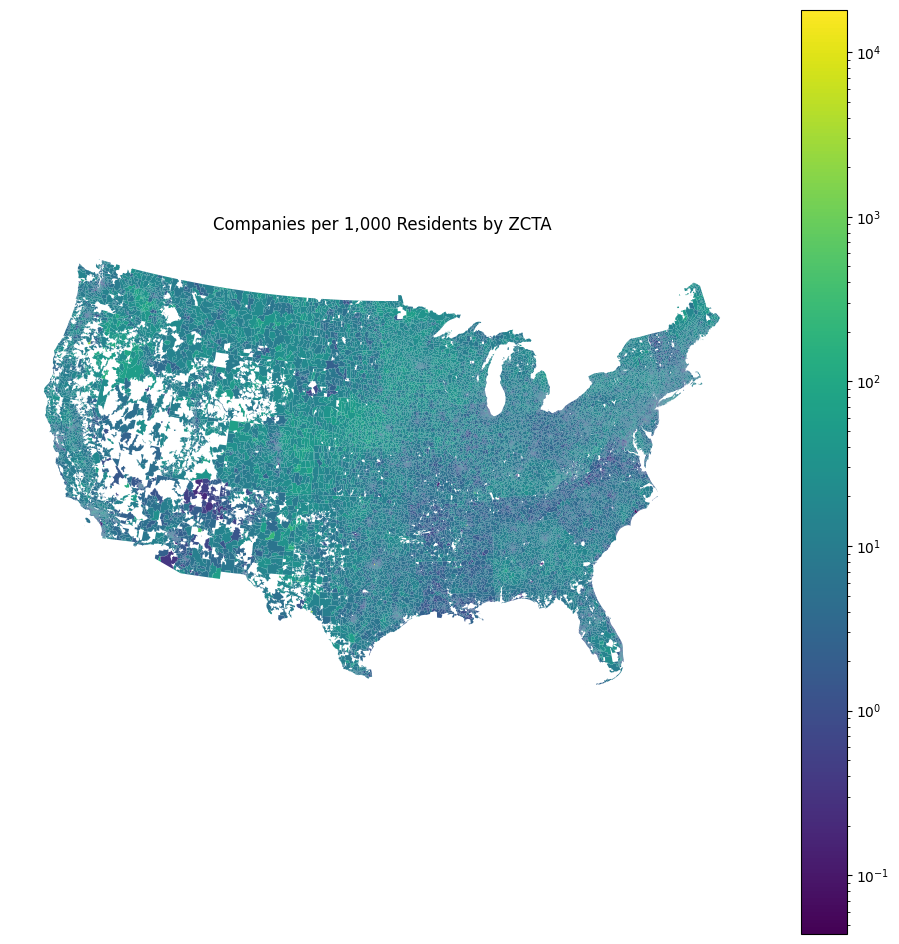

In [34]:
import matplotlib as mpl

norm = mpl.colors.LogNorm(
    vmin=gdf_contig["companies_per_1000"].replace(0, 0.001).min(),  # avoid log(0)
    vmax=gdf_contig["companies_per_1000"].max()
)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_contig.plot(
    column="companies_per_1000",
    cmap="viridis",
    legend=True,
    linewidth=0,
    ax=ax,
    norm=norm
)

ax.set_title("Companies per 1,000 Residents by ZCTA")
ax.axis("off")
plt.show()

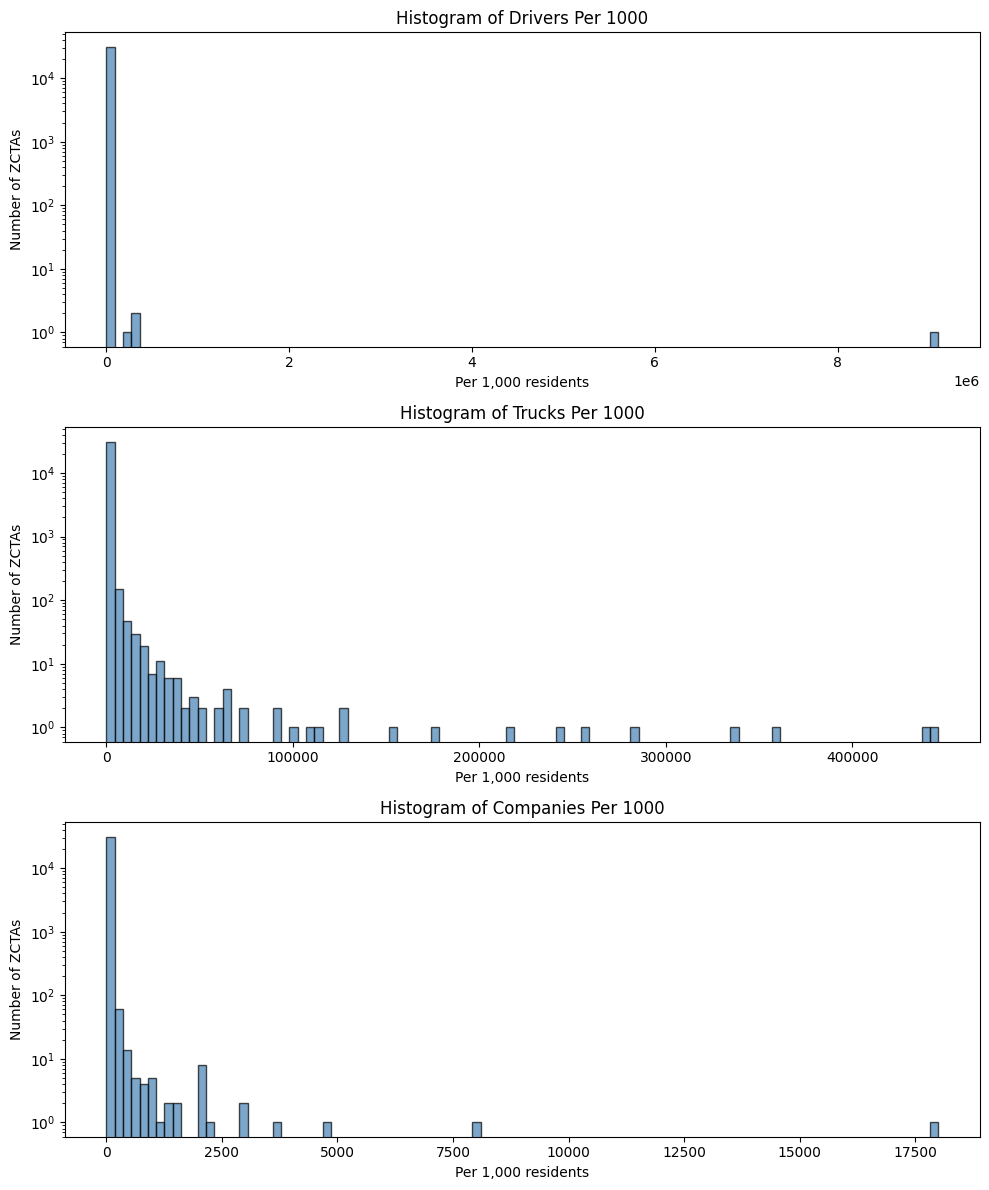

In [35]:
columns = ["drivers_per_1000", "trucks_per_1000", "companies_per_1000"]

fig, axes = plt.subplots(len(columns), 1, figsize=(10, 12))

for ax, col in zip(axes, columns):
    gdf_contig[col].plot.hist(
        bins=100,
        alpha=0.7,
        ax=ax,
        color="steelblue",
        edgecolor="black"
    )
    ax.set_title(f"Histogram of {col.replace('_', ' ').title()}")
    ax.set_xlabel("Per 1,000 residents")
    ax.set_ylabel("Number of ZCTAs")
    ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [36]:
pdf = df.to_pandas()

In [37]:
pdf["miles_per_driver"] = pdf["recent_mileage"] / pdf["driver_total"]

In [38]:
cols_to_plot = ["recent_mileage", "nbr_power_unit", "driver_total", "drivers_per_unit", "miles_per_driver"]
pdf_plot = pdf[pdf[cols_to_plot].notna().all(axis=1) & (pdf["driver_total"] > 0)]

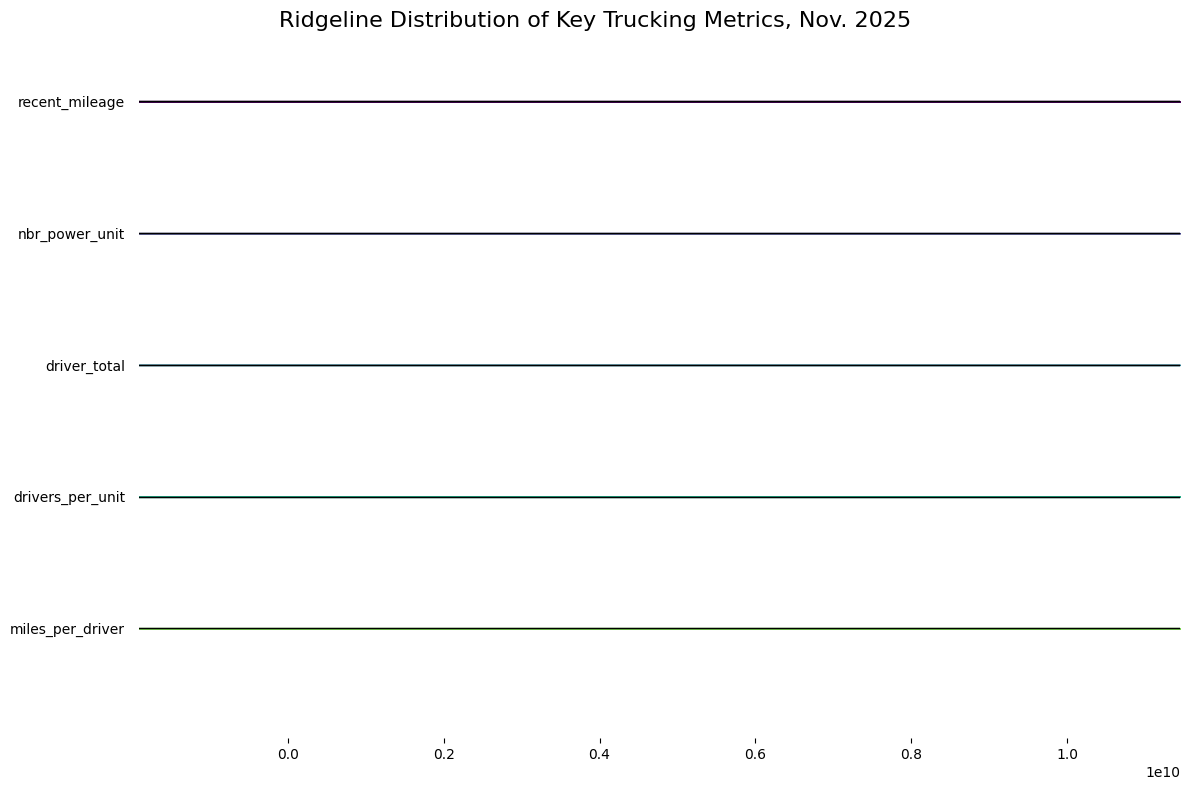

In [39]:
import joypy

fig, axes = joypy.joyplot(
    pdf_plot[cols_to_plot],
    kind="kde",
    overlap=1,
    figsize=(12, 8),
    colormap=plt.cm.viridis,
    linewidth=1
)

plt.suptitle("Ridgeline Distribution of Key Trucking Metrics, Nov. 2025", fontsize=16)
plt.show()

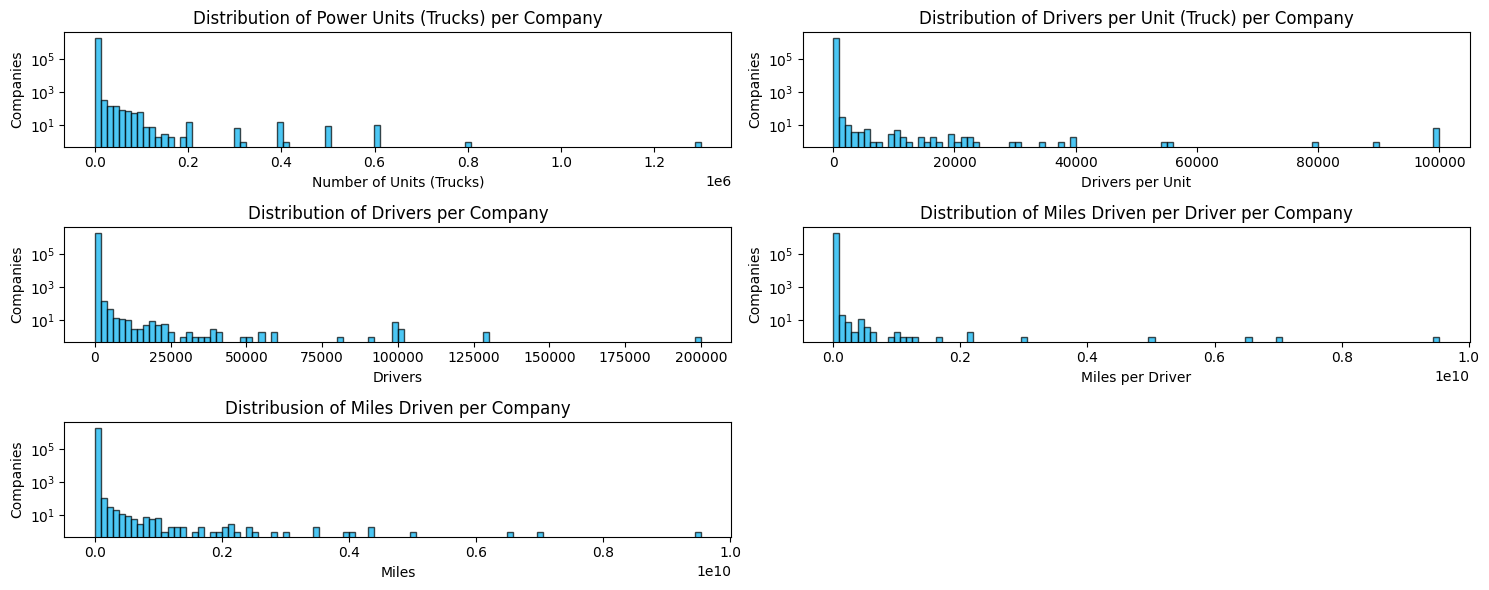

In [55]:
import math

cols_to_plot = ["nbr_power_unit","drivers_per_unit",
                "driver_total", "miles_per_driver",
                "recent_mileage"]
xaxes = ["Number of Units (Trucks)", "Drivers per Unit","Drivers",  "Miles per Driver", "Miles"]
titles = ["Distribution of Power Units (Trucks) per Company",
          "Distribution of Drivers per Unit (Truck) per Company",
          "Distribution of Drivers per Company",
          "Distribution of Miles Driven per Driver per Company",
          "Distribusion of Miles Driven per Company"]
# Determine grid size
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*2))  # adjust width/height as needed
axes = axes.flatten()  # flatten in case of 1D array

for ax, col, x, title in zip(axes, cols_to_plot, xaxes, titles):
    pdf_plot[col].plot.hist(
        bins=100,
        alpha=0.7,
        ax=ax,
        color="#00b0f0",
        edgecolor="black"
    )
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel("Companies")
    ax.set_yscale("log")  # log-scale for skewed data

# Remove any unused axes
for ax in axes[len(cols_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("november_histograms.png")
plt.show()

In [47]:
df.shape

(2091343, 50)